**==============================================================================================================================**

# ======================= Assignment 5 ==========================

## Amazon Fine Food Reviews Analysis and Logistic Regression Classification

​
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>
​
Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 
​
Attribute Information:
​
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review
​

#### Objective:
1] Implement Logistic Regression

2] Best Lambda using CV (GridSearch CV & Random Search CV)

3] L2 and L1 Regularization

4] L1 Reg. Play (Increase Lambda: No. of Non Zero elements)

5] Feature Importance

6] Confusion Matrix

Classify the Score based on Review and Calculate TPR, FPR, TNR, FNR based on Confusion Matrix

**==============================================================================================================================**

In [69]:
# ============================== loading libraries ===========================================
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
import string
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from IPython.display import Image
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import re

import sqlite3


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.sparse import find
# =============================================================================================

In [2]:
con = sqlite3.connect('database.sqlite') 
amzn = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("Shape of Amzn Dataframe :",amzn.shape)
print("\n")
print("Head(2) of Amzn Dataframe")
print("**************************")
amzn.head(2)

Shape of Amzn Dataframe : (525814, 10)


Head(2) of Amzn Dataframe
**************************


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Function to impute the review to -1- "Positive" (Rating of 4 or 5) or -0- "Negative" (rating of 1 or 2).**

In [3]:
def part(data):
    if data > 3:
        return 1
    else:
        return 0

**Applying Function to Amazon['Score'] factor**

In [4]:
amzn['Score'] = amzn['Score'].map(part)
print("Shape of Amazon Dataframe :",amzn.shape)
amzn.head(2)

print("Score Value: \n",amzn['Score'].value_counts())

Shape of Amazon Dataframe : (525814, 10)
Score Value: 
 1    443777
0     82037
Name: Score, dtype: int64


# Data Preprocessing

**Checking how many observations have Duplicated values in dataset with Variables['UserId','ProfileName','Score','Time']**

**The value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible,
  So Going to keep all the observations which have HelpfulnessNumerator is less than or Equal to HelpfulnessDenominator.**

Sum Of Duplicated Value ['UserId','ProfileName','Score','Time']:  192811

Sum After Removing Duplicated:  0

Shape of Amazon Dataset After Duplication Removal and Erro:  (333001, 10)

1    277625
0     55376
Name: Score, dtype: int64


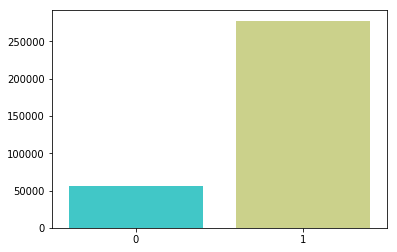

In [5]:
print("Sum Of Duplicated Value ['UserId','ProfileName','Score','Time']: ",amzn.duplicated(subset=['UserId','ProfileName','Score','Time']).sum())
amzn = amzn.drop_duplicates(subset=['UserId','ProfileName','Score','Time'], keep='first')
print()
print("Sum After Removing Duplicated: ",amzn.duplicated().sum())

amzn = amzn[amzn['HelpfulnessNumerator'] <= amzn['HelpfulnessDenominator']]
print()
#Before starting the next phase of preprocessing lets see the number of entries left
print("Shape of Amazon Dataset After Duplication Removal and Erro: ",amzn.shape)
print()
#How many positive and negative reviews are present in our dataset?
class_bal = amzn['Score'].value_counts()
print(class_bal)

#Plotting barplot for target variable to compare balance between them.
sns.barplot(class_bal.index, class_bal.values, palette="rainbow")

**Function which will**

1] Remove all html sets of sentences from reviews

2] Remove all punctuation present in reviews as are not necessary for analysis and modeling

In [6]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

**Code Working**

1] Remove HTMl tags

2] Split the reviews

3] Converting reviews to lower case

4] Removing Stop words

5] Storing of all words used to describe positive reviews and negative reviews.

In [7]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''


for sent in amzn['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if (amzn['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(amzn['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

**Adding a column of CleanedText which displays the data after pre-processing of the review**

**Taking Sample of 100000 Observation after preprocess of data and after sorting all the data.**

In [8]:
amzn['CleanedText'] = final_string
amzn = amzn.sort_values('Time')

amazon = amzn.head(100000)
print(amazon.shape)

amazon.head(2)

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


# =============================================================

# =============================================================

**Spliting data to train and test as 80-20 for further steps and analysis**

In [9]:
X_train = amazon['CleanedText'].head(80000)
X_test = amazon['CleanedText'].tail(20000)
y_train = amazon['Score'].head(80000)
y_test = amazon['Score'].tail(20000)

print("Text:  ",len(X_train), len(X_test), len(X_train) + len(X_test))
print("Score: ",len(y_train), len(y_test), len(y_train) + len(y_test))

Text:   80000 20000 100000
Score:  80000 20000 100000


# Functions to call again and again whenever needed

**Function takes Train and test data to find better Alpha value and GridCv Function to perform Cross Validation to find Better Alpha (Laplace Smoothing)** 

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

**Fucntion with C for best C**

**Function For GridSearch CV and RandomSearchCV**

In [54]:
def best_Lambda_train_test(X_train, y_train, X_test, y_test):
    c = [1,10,100,10**-1,10**-2,10**-3]
    for i in c:
        # instantiate learning model (Lambda = 6 Values)
        Log_Model = LogisticRegression(C=i)

        # fitting the model on crossvalidation train
        Log_Model.fit(X_train, y_train)
        
        # predict the response on the crossvalidation train
        pred = Log_Model.predict(X_test)

        # evaluate Accuracy
        acc = accuracy_score(y_test, pred, normalize=True) * float(100)
        F1_Score = f1_score(y_test, pred,average='weighted') * float(100)
        
        print("====================================================")
        print('Accuracy With C i.e (1/Lambda) = ',i,' is ',acc,' %')
        print('F1 Score With C i.e (1/Lambda) = ',i,' is ',F1_Score,' %')
        print("====================================================")
        print()
        

        
def Grid_CV(X_train, y_train): 
    params = [{'C':[1,10,100,10**-1,10**-2,10**-3], 'penalty':['l1','l2']}]
    tuned_classifier = LogisticRegression()
    grid_search = GridSearchCV(estimator=tuned_classifier, param_grid=params, scoring = 'f1', cv = 3)
    grid_search = grid_search.fit(X_train, y_train)
    print("Grid Search CV Best 'Alpha' According to F1_Score")        
    print("=================================================")
    print(grid_search.best_params_)
    
    

    
    
def Random_CV(X_train, y_train):
    params = {'C': [10**-3, 1], 'penalty':['l1','l2']}
    tuned_classifier = LogisticRegression()
    rand_search = RandomizedSearchCV(estimator=tuned_classifier, param_distributions=params, scoring = 'f1', cv = 3)
    rand_search = rand_search.fit(X_train, y_train)
    print("Random Search CV Best 'Lambda' According to F1_Score")        
    print("====================================================")
    print(rand_search.best_params_)

In [12]:
def L1_Error_NonZero(X_train, y_train):
    c = [1,10,100,10**-1,10**-2,10**-3]
    for i in c:
        Log_Model = LogisticRegression(C=i, penalty='l1')
        Log_Model.fit(X_train, y_train)
        w = Log_Model.coef_
        print("For C = ",i,"Non Zero Features Are: ",np.count_nonzero(w),"Out Of",X_train.shape[1],"Features")
        print()

**Function to print Confusion Matrix, CV Score, Classification Report, Plot Confusion Matrix and Get Accuracy of Model on Test Data with Defined Classifier with Better Alpha**

In [158]:
def fit_predict_performance_CM_CV(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    
    cv_perfor = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=3)
    k_fold_performance = cv_perfor.mean()
    
    print("K-fold cross validation score of model for k = 3 is :")
    print(k_fold_performance * float(100))
    print("====================================")
    print("====================================")
    print()
    
    print("Correct Classified Data Point: ",accuracy_score(y_test, prediction, normalize=False))
    print()
    print("Correct % Classified Data Point: ",accuracy_score(y_test, prediction) * 100 ,"%")
    print("====================================")
    print()
    print("F1-Score on Test set:",f1_score(y_test, prediction)*100,"%")
    print("====================================")
    print()
    
    print("====== Confusion matrix ======= ")
    cm = confusion_matrix(y_test,prediction)
    print(cm)
    

    df_CM = pd.DataFrame(cm)
    print("Confusion Matrix")
    print("==================")
    print(df_CM)
    print("==================")
    fig = plt.figure()
    sns.heatmap(df_CM, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print()
    print("====== Classification Report ======= ")
    cr = classification_report(y_test,prediction)
    print(cr)

In [14]:
### Function for Word Cloud to Visualize Important Features in Positive and Negative Review or Most occuring Words in Reviews

def wordimpcloud(data):
    # nltk.FreqDist generates a tally of the number of times each word appears
    # and stores the results in a special dictionary.
    fdist = nltk.FreqDist(data)

    # This is the dictionary we'll use for the word cloud.
    # Loaded with the FOR loop below.
    word_dict = {}

    for key in fdist:
        word_dict[key] = fdist[key]

    wordCloud = WordCloud(max_words= 500, height= 1500, width= 3000)

    print("\nWord cloud with most frequently occurring Words (unigrams).")

    wordCloud.generate_from_frequencies(word_dict)
    plt.figure(figsize=(15,30))
    plt.title('Most frequently occurring words (unigrams)')
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Function for Pertubation Test to find Multi-collinearity

In [126]:
def pertubation(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
    print("F1 Score on test set: %0.2f%%"%(f1_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(classifier.coef_))
    print()



    #Weights before adding random noise
    weights1 = find(classifier.coef_[0])[2]
    print("Weights Before Adding Random Noise")
    print("=================================")
    print(weights1[:30])
    print()


    X_train_Eplsilon = X_train


    #Random noise
    epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_Eplsilon)[0].size,))


    #Getting the postions(row and column) and value of non-zero datapoints 
    a,b,c = find(X_train_Eplsilon)

    #Introducing random noise to non-zero datapoints
    X_train_Eplsilon[a,b] = epsilon + X_train_Eplsilon[a,b]
    print("Scoring AFter Adding Random Noise to Train Data")
    print()

    #Training on train data having random noise
    classifier.fit(X_train_Eplsilon,y_train)
    y_pred = classifier.predict(X_test)
    print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, y_pred)*100))
    print("F1 Score on test set: %0.2f%%"%(f1_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(classifier.coef_))
    print()

    #Weights after adding random noise
    weights2 = find(classifier.coef_[0])[2]
    print("Weights After Adding Random Noise")
    print("=================================")
    print(weights2[:30])

    print()
    weights_diff = (abs(weights1 - weights2)/weights1) * 100
    print("Number of Multicollinear Features in Dataset: ",weights_diff[np.where(weights_diff > 30)].size)

### Function to find top features in Positive and negative Reviews

In [127]:
def top_features(vectorizer, model, n=25):
    features = vectorizer.get_feature_names()
    coef_and_fn = sorted(zip(clf.coef_[0], features))
    top_features = zip(coef_and_fn[:n], coef_and_fn[:-(n + 1):-1])
    print("\tPositive\t\t\t\t\tNegative")
    print("_____________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top_features:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [15]:
y_train = y_train.values
y_test = y_test.values

# Bag Of Words(BoW)

**Creating Bag of words using CountVectorizer() function and printing Shape of same and Unique words present in reviews**

In [171]:
#BoW
CV = CountVectorizer() #in scikit-learn
Bow_X_train = CV.fit_transform(X_train)
Bow_X_test = CV.transform(X_test)
print("Shape of BOW vectorizer: ",Bow_X_train.get_shape(), Bow_X_test.get_shape())
print("Number of unique words in 'Bow_X_train': ", Bow_X_train.get_shape()[1])
print("Number of unique words in 'Bow_X_test': ", Bow_X_test.get_shape()[1])

Shape of BOW vectorizer:  (80000, 33721) (20000, 33721)
Number of unique words in 'Bow_X_train':  33721
Number of unique words in 'Bow_X_test':  33721


**Calling classifier function with "Bow_X_train, y_train, Bow_X_test, y_test" for better ALpha with Highest accuracy for BOW**

In [19]:
warnings.filterwarnings('ignore')
best_Lambda_train_test(Bow_X_train, y_train, Bow_X_test, y_test)

Accuracy With C i.e (1/Lambda) =  1  is  91.36999999999999  %
F1 Score With C i.e (1/Lambda) =  1  is  90.95183755650586  %

Accuracy With C i.e (1/Lambda) =  10  is  91.25999999999999  %
F1 Score With C i.e (1/Lambda) =  10  is  90.91759758557073  %

Accuracy With C i.e (1/Lambda) =  100  is  91.065  %
F1 Score With C i.e (1/Lambda) =  100  is  90.75118974038087  %

Accuracy With C i.e (1/Lambda) =  0.1  is  91.46  %
F1 Score With C i.e (1/Lambda) =  0.1  is  90.79931328940168  %

Accuracy With C i.e (1/Lambda) =  0.01  is  90.095  %
F1 Score With C i.e (1/Lambda) =  0.01  is  88.6285304846617  %

Accuracy With C i.e (1/Lambda) =  0.001  is  86.75500000000001  %
F1 Score With C i.e (1/Lambda) =  0.001  is  82.19962613027215  %



### Grid Search and Random Search for Best "C" and Penalty for Modelling

In [55]:
Grid_CV(Bow_X_train, y_train)

Grid Search CV Best 'Alpha' According to F1_Score
{'C': 0.1, 'penalty': 'l2'}


In [56]:
Random_CV(Bow_X_train, y_train)

Random Search CV Best 'Lambda' According to F1_Score
{'penalty': 'l2', 'C': 1}


In [22]:
L1_Error_NonZero(Bow_X_train, y_train)

For C =  1 Non Zero Features Are:  4249 Out Of 33721 Features

For C =  10 Non Zero Features Are:  10104 Out Of 33721 Features

For C =  100 Non Zero Features Are:  13403 Out Of 33721 Features

For C =  0.1 Non Zero Features Are:  870 Out Of 33721 Features

For C =  0.01 Non Zero Features Are:  138 Out Of 33721 Features

For C =  0.001 Non Zero Features Are:  7 Out Of 33721 Features



### Modelling with HyperTune Parameter

K-fold cross validation score of model for k = 3 is :
88.28500224636714

Correct Classified Data Point:  18138

Correct % Classified Data Point:  90.69 %

F1-Score on Test set: 94.67391304347825 %

====== Confusion matrix ======= 
[[ 1589  1355]
 [  507 16549]]
Confusion Matrix
      0      1
0  1589   1355
1   507  16549

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.76      0.54      0.63      2944
           1       0.92      0.97      0.95     17056

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.84      0.76      0.79     20000
weighted avg       0.90      0.91      0.90     20000



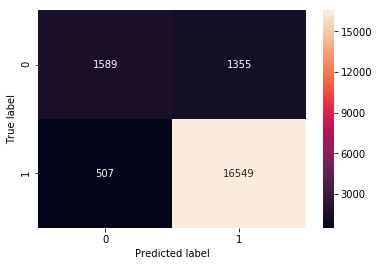

In [159]:
classifier = LogisticRegression(C= 0.1, penalty='l2')
fit_predict_performance_CM_CV(classifier, Bow_X_train, y_train, Bow_X_test, y_test)

K-fold cross validation score of model for k = 3 is :
88.39500148076695

Correct Classified Data Point:  18186

Correct % Classified Data Point:  90.93 %

F1-Score on Test set: 94.76055687135347 %

====== Confusion matrix ======= 
[[ 1782  1162]
 [  652 16404]]
Confusion Matrix
      0      1
0  1782   1162
1   652  16404

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      2944
           1       0.93      0.96      0.95     17056

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.83      0.78      0.81     20000
weighted avg       0.90      0.91      0.91     20000



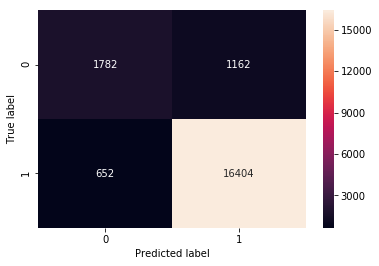

In [160]:
classifier = LogisticRegression(C= 1, penalty='l2')
fit_predict_performance_CM_CV(classifier, Bow_X_train, y_train, Bow_X_test, y_test)

### Top Positive and Negative Features in Reviews in Bow Vectorizer

In [112]:
top_features(CV, classifier)

	Positive					Negative
_____________________________________________________________________________________
	-4.5793	disappoint     				5.8168	great          
	-2.9177	worst          				4.4599	love           
	-2.7002	bad            				4.3696	best           
	-2.6827	money          				3.3089	delici         
	-2.6395	terribl        				3.0170	good           
	-2.5511	return         				2.8470	excel          
	-2.4631	aw             				2.8120	perfect        
	-2.4475	wast           				2.4949	favorit        
	-2.4435	horribl        				2.3744	find           
	-2.3774	tast           				2.3657	nice           
	-2.2931	stale          				2.2988	wonder         
	-2.1974	thought        				1.9398	easi           
	-2.0879	threw          				1.9235	tasti          
	-2.0732	bland          				1.8016	alway          
	-2.0296	would          				1.8010	keep           
	-2.0076	unfortun       				1.7880	enjoy          
	-1.9815	mayb           				1.7204	thank          
	-1.9345	away           

# Perturbation Test BoW

In [ ]:
classifier = LogisticRegression(C= 1, penalty='l2')
pertubation(classifier, Bow_X_train, y_train, Bow_X_test, y_test)

**==================================================================================================================================**

**Observation on BoW Logistic Regression:**

1] After Implementing different approach to find better Lambda Or C for the Bow Model,

    Such as: 
    - Different Lambda|C Model
    - GridSearchCV : C = 0.1 and Lambda = 10
    - RandomSearchCV : C = 1 and Lambda = 1
                      - With L2 Regularizer
    
        Lambda = 10 i.e C = 0.1, came out to be Best Lambda|C for the Modeling with GridSearchCV and By Implementing Train Test Result.
         Lambda = 1 i.e C = 1, came out to be Best Lambda|C for the Modeling with RandomSearchCV
         
### For Lambda = 1 i.e C = 1 : RandomSearchCV Result, Penalty: L2

    - Test Result: 90.93 %
    - CV Result: 88.39 %
    
    - Accuracy:
        - F1 Score: 94 %
        - Recall: 79 %
        - Precision: 85 %
        
    - Correctly Classified Points: 18274/20000
    
### For Lambda = 10 i.e C = 0.1 : GridSearchCV Result, Penalty: L2

    - Test Result: 90.69 %
    - CV Result: 88.28 %
    
    - Accuracy:
        - F1 Score: 94 %
        - Recall: 77 %
        - Precision: 86 %
        
    - Correctly Classified Points: 18292/20000
    
 
After Comparing Result of Lambda = 10 and 1, We can observe that even if our Lambda is 1 and 10 there is not a much difference in Accuracy in BOW model and seems 1 and 10 is best choice for Lambda.

**==================================================================================================================================**

# Most Frequent Feature Words in Postive and Negative Reviews

In [25]:
freq_positive_dist=nltk.FreqDist(all_positive_words)
freq_negative_dist=nltk.FreqDist(all_negative_words)
print("Most Common and Top Feature Words in Positive Review")
print("====================================================")
print(freq_positive_dist.most_common(50))
print()
print("Most Common and Top Feature Words in Negative Review")
print("====================================================")
print(freq_negative_dist.most_common(50))

Most Common and Top Feature Words in Positive Review
[('like', 124538), ('tast', 115988), ('good', 100085), ('flavor', 96603), ('love', 96593), ('use', 93419), ('great', 92881), ('one', 87018), ('product', 82702), ('tri', 79105), ('tea', 74536), ('coffe', 72974), ('make', 67057), ('get', 65275), ('food', 58135), ('would', 50525), ('time', 50143), ('buy', 49144), ('realli', 47133), ('eat', 46242), ('amazon', 45696), ('price', 44206), ('find', 44161), ('best', 43617), ('much', 43079), ('order', 42989), ('also', 42655), ('dont', 41800), ('littl', 41225), ('drink', 38953), ('well', 38691), ('store', 38196), ('dog', 37783), ('ive', 37276), ('bag', 36833), ('even', 34969), ('day', 32899), ('better', 32811), ('mix', 32739), ('chocol', 32254), ('year', 31394), ('recommend', 31119), ('water', 29556), ('sweet', 29509), ('sugar', 29070), ('box', 29032), ('found', 28435), ('cup', 28012), ('first', 27732), ('give', 26991)]

Most Common and Top Feature Words in Negative Review
[('tast', 33462), ('li

## Important Word Features In Positive Reviews


Word cloud with most frequently occurring Words (unigrams).


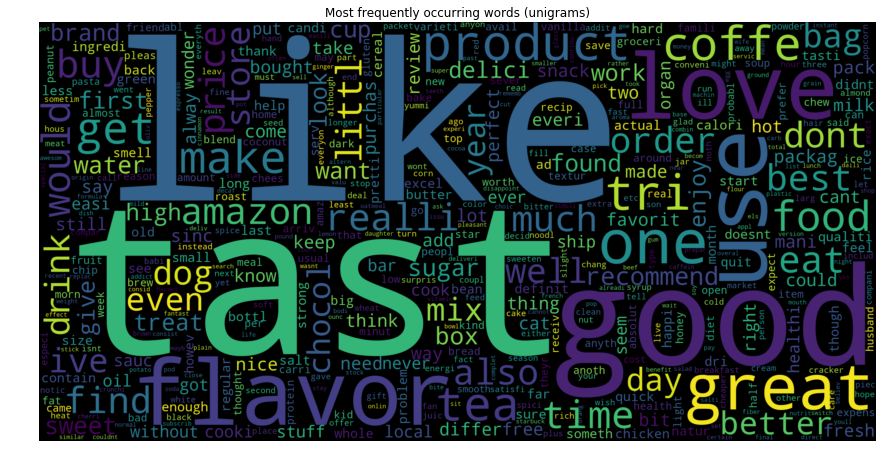

In [26]:
wordimpcloud(all_positive_words)

## Important Word Features In Negative Reviews


Word cloud with most frequently occurring Words (unigrams).


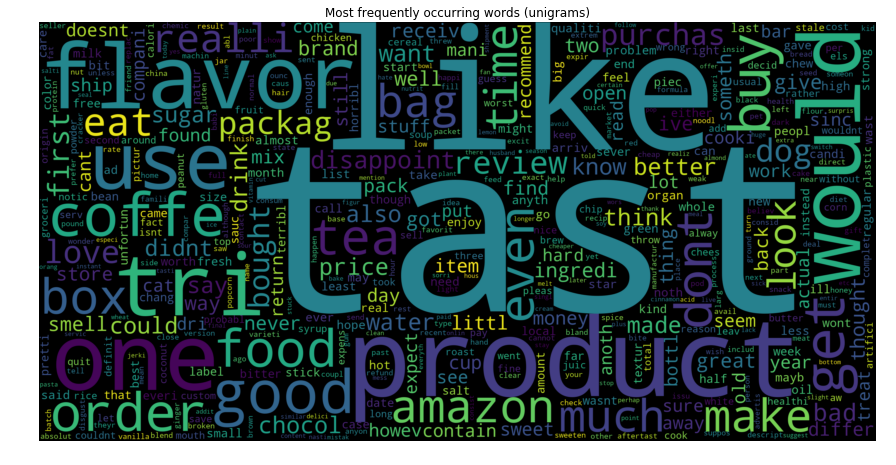

In [27]:
wordimpcloud(all_negative_words)

# Tf-Idf

**Tfidf and finding Shape of data and Unique words in Dataframe**

In [121]:
tf_idf = TfidfVectorizer()
Tfidf_X_train = tf_idf.fit_transform(X_train)
Tfidf_X_test = tf_idf.transform(X_test)
print("Shape of BOW vectorizer: ",Tfidf_X_train.get_shape(), Tfidf_X_test.get_shape())
print("Number of unique words in 'Tfidf_X_train': ", Tfidf_X_train.get_shape()[1])
print("Number of unique words in 'Tfidf_X_test': ", Tfidf_X_test.get_shape()[1])

Shape of BOW vectorizer:  (80000, 33721) (20000, 33721)
Number of unique words in 'Tfidf_X_train':  33721
Number of unique words in 'Tfidf_X_test':  33721


# Top 10 Features in Tfidf

In [29]:
# source: https://buhrmann.github.io/tfidf-analysis.html
features = tf_idf.get_feature_names()
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(Tfidf_X_train[1,:].toarray()[0],features,10)
top_tfidf

,feature,tfidf
0,book,0.365523
1,televis,0.269617
2,song,0.259891
3,preschool,0.258105
4,thirti,0.239940
5,teach,0.239476
6,seri,0.237260
7,student,0.216004
8,sister,0.189603
9,air,0.184065


**Calling classifier function with "Tfidf_X_train, y_train, Tfidf_X_test, y_test" for better K with Highest accuracy for Tfidf data**

In [30]:
best_Lambda_train_test(Tfidf_X_train, y_train, Tfidf_X_test, y_test)

Accuracy With C i.e (1/Lambda) =  1  is  91.4  %
F1 Score With C i.e (1/Lambda) =  1  is  90.56802429815217  %

Accuracy With C i.e (1/Lambda) =  10  is  91.685  %
F1 Score With C i.e (1/Lambda) =  10  is  91.23827757904058  %

Accuracy With C i.e (1/Lambda) =  100  is  90.62  %
F1 Score With C i.e (1/Lambda) =  100  is  90.29456100217865  %

Accuracy With C i.e (1/Lambda) =  0.1  is  87.97500000000001  %
F1 Score With C i.e (1/Lambda) =  0.1  is  84.47719934488453  %

Accuracy With C i.e (1/Lambda) =  0.01  is  85.28  %
F1 Score With C i.e (1/Lambda) =  0.01  is  78.50473229706391  %

Accuracy With C i.e (1/Lambda) =  0.001  is  85.28  %
F1 Score With C i.e (1/Lambda) =  0.001  is  78.50473229706391  %



### Grid Search and Random Search for Best "C" and Penalty for Modelling

In [59]:
Grid_CV(Tfidf_X_train, y_train)

Grid Search CV Best 'Alpha' According to F1_Score
{'C': 10, 'penalty': 'l2'}


In [60]:
Random_CV(Tfidf_X_train, y_train)

Random Search CV Best 'Lambda' According to F1_Score
{'penalty': 'l1', 'C': 1}


In [33]:
L1_Error_NonZero(Tfidf_X_train, y_train)

For C =  1 Non Zero Features Are:  1449 Out Of 33721 Features

For C =  10 Non Zero Features Are:  7685 Out Of 33721 Features

For C =  100 Non Zero Features Are:  12983 Out Of 33721 Features

For C =  0.1 Non Zero Features Are:  216 Out Of 33721 Features

For C =  0.01 Non Zero Features Are:  5 Out Of 33721 Features

For C =  0.001 Non Zero Features Are:  0 Out Of 33721 Features



### Modeliing with Hypertunning data

K-fold cross validation score of model for k = 3 is :
92.52625084142497

Correct Classified Data Point:  18337

Correct % Classified Data Point:  91.685 %

F1 Score:  95.21755384925086 %

====== Confusion matrix ======= 
[[ 1782  1162]
 [  501 16555]]
Confusion Matrix
      0      1
0  1782   1162
1   501  16555

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.78      0.61      0.68      2944
           1       0.93      0.97      0.95     17056

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.86      0.79      0.82     20000
weighted avg       0.91      0.92      0.91     20000



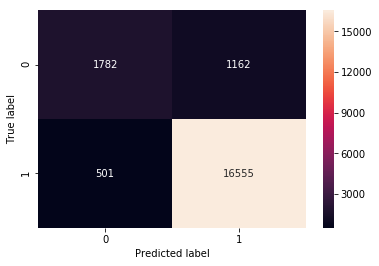

In [128]:
classifier = LogisticRegression(C= 10, penalty='l2')
fit_predict_performance_CM_CV(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

K-fold cross validation score of model for k = 3 is :
92.16375152882028

Correct Classified Data Point:  18280

Correct % Classified Data Point:  91.4 %

F1 Score:  95.11224779766978 %

====== Confusion matrix ======= 
[[ 1545  1399]
 [  321 16735]]
Confusion Matrix
      0      1
0  1545   1399
1   321  16735

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.83      0.52      0.64      2944
           1       0.92      0.98      0.95     17056

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.88      0.75      0.80     20000
weighted avg       0.91      0.91      0.91     20000



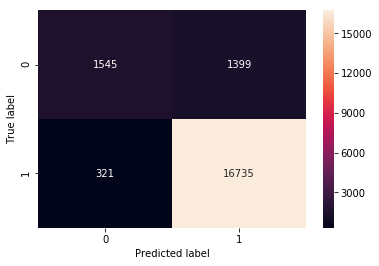

In [35]:
classifier = LogisticRegression(C= 1, penalty='l1')
fit_predict_performance_CM_CV(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

## Pertubation Test On Tfidf

In [123]:
classifier = LogisticRegression(C= 10, penalty='l2')
pertubation(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

Accuracy on test set: 91.68%
F1 Score on test set: 95.21%
Non Zero weights: 33721

Weights Before Adding Random Noise
[ 8.58076407e-03  7.80441395e-02  1.83985616e-01  7.06253931e-03
  1.92342025e-02  1.25843417e-01  2.07344763e-02 -7.02874721e-01
  4.66566402e-02  8.99907635e-04  1.04785276e-02  3.90563635e-03
 -6.30255549e-01  4.57432632e-01  4.80207173e-01  4.11135161e-02
  4.04171867e-02  6.11323332e-01  1.74527845e+00 -1.04673471e+00
  1.72050379e-02  6.21994176e-02  3.63521339e-01  2.60850689e-01
  4.83470167e-01 -2.18228991e-02  5.87351248e-02 -4.86034447e-01
  1.26194276e-01  3.26694413e-02]

Scoring AFter Adding Random Noise to Train Data

Accuracy on test set: 91.69%
F1 Score on test set: 95.22%
Non Zero weights: 33721

Weights After Adding Random Noise
[ 7.82737110e-03  7.88900714e-02  1.84420219e-01  6.68747701e-03
  1.94817348e-02  1.25955811e-01  2.10045126e-02 -7.02107881e-01
  4.69963340e-02  8.71350798e-04  1.05127808e-02  3.71553642e-03
 -6.24403982e-01  4.58303900e-0

### Top Features In Positive and Negative Reviews in Tfidf

In [129]:
top_features(tf_idf, classifier)

	Positive					Negative
_____________________________________________________________________________________
	-4.5793	disappoint     				5.8168	great          
	-2.9177	worst          				4.4599	love           
	-2.7002	bad            				4.3696	best           
	-2.6827	money          				3.3089	delici         
	-2.6395	terribl        				3.0170	good           
	-2.5511	return         				2.8470	excel          
	-2.4631	aw             				2.8120	perfect        
	-2.4475	wast           				2.4949	favorit        
	-2.4435	horribl        				2.3744	find           
	-2.3774	tast           				2.3657	nice           
	-2.2931	stale          				2.2988	wonder         
	-2.1974	thought        				1.9398	easi           
	-2.0879	threw          				1.9235	tasti          
	-2.0732	bland          				1.8016	alway          
	-2.0296	would          				1.8010	keep           
	-2.0076	unfortun       				1.7880	enjoy          
	-1.9815	mayb           				1.7204	thank          
	-1.9345	away           

**==================================================================================================================================**

**Observation on Tfidf Logestic Regression:**

1] After Implementing different approach to find better Lambda Or C for the Tfidf Model,

    Such as: 
    - Different Lambda|C Model
    - GridSearchCV : C = 10 and Lambda = 0.1 With L2 Penalty
    - RandomSearchCV : C = 1 and Lambda = 1 With L1 Penalty
    
        Lambda = 0.1 i.e C = 10, came out to be Best Lambda|C for the Modeling with GridSearchCV and By Implementing Train Test Result.
         Lambda = 1 i.e C = 1, came out to be Best Lambda|C for the Modeling with RandomSearchCV
         
### For Lambda = 1 i.e C = 1 : RandomSearchCV Result, Penalty=L1

    - Test Result: 91.4 %
    - CV Result: 92.16 %
    
    - Accuracy:
        - F1 Score: 95.2 %
        - Recall: 75 %
        - Precision: 88 %
        
    - Correctly Classified Points: 18280/20000
    
### For Lambda = 10 i.e C = 0.1 : GridSearchCV Result, Penalty=L2

    - Test Result: 91.68 %
    - CV Result: 92.5 %
    
    - Accuracy:
        - F1 Score: 95.2 %
        - Recall: 79 %
        - Precision: 86 %
        
    - Correctly Classified Points: 18337/20000
    
 
After Comparing Result of Lambda = 10 and 1, We can observe that even if our Lambda is 1 and 10 there is not a much difference in Accuracy in Tfidf model and seems 1 and 10 is best choice for Lambda and Tfidf Model performance is Better than Bow Model.

**==================================================================================================================================**

# Tfidf Word2Vec

### Word2Vec

In [130]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train[:]:
    list_of_sent.append(sent.split())

In [131]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in X_test[:]:
    list_of_sent_test.append(sent.split())

In [132]:
print(list_of_sent[0])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [133]:
# min_count = 10 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent, min_count= 10 ,size = 150, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 10 times ",len(w2v_words))
print("\nsample words:", w2v_words[0:50])

number of words that occured minimum 10 times  8096

sample words: ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school']


In [134]:
w2v_model.wv['love']

array([ 0.57351893, -0.12121652,  0.9630936 ,  0.26809695, -1.0455412 ,
        1.7987866 , -0.52784234,  0.4451499 , -0.12114255, -0.7472313 ,
       -0.28741693, -0.7380046 ,  0.2949157 ,  0.11635347,  0.20948038,
       -0.22128616,  1.2125393 , -0.7573123 , -0.00398611,  0.055302  ,
       -0.15025268,  0.53759766,  0.41808736, -0.60585135, -0.20367564,
        0.2940408 , -1.0736163 , -0.26345056,  0.24493971, -0.38720557,
        1.0958744 , -0.9285137 , -0.07707049,  2.1452434 , -0.13280506,
        0.7238965 ,  0.06084023,  0.16059107, -0.5720827 ,  0.3015923 ,
       -0.39470488, -0.81877977,  1.5167457 ,  0.5317351 , -1.1777977 ,
       -0.6699166 , -0.42737114,  0.27056304, -0.7986126 , -1.038112  ,
       -1.5916939 , -1.726451  , -0.06121129,  0.8462331 , -2.074271  ,
       -0.17525443, -0.17101727,  0.14118688, -1.4402809 ,  0.06144594,
       -1.0680841 , -0.46160805,  0.7092158 , -1.0948099 , -0.33313623,
        0.05184694,  0.86357343,  0.18053328,  0.41412708,  1.09

## Tfidf W2V

**Creating Tfidf for Word 2 Vector, Creating dictionary with each word as key and values as its vector and computed tfidf.**

In [135]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

**Creating Vector of Train data using W2V Model**

In [136]:
tfidf_feat = model.get_feature_names()
# average Word2Vec
# compute average word2vec for each review in train data

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(150) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            Tf_idf_w2v_train = dictionary[word]*sent.count(word)
            #Tf_idf_w2v_train = Tfidf_X_train[row, tf_idf.get_feature_names().index(word)]
            sent_vec += (vec * Tf_idf_w2v_train)
            weight_sum += Tf_idf_w2v_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

**Creating Vector of Train data using W2V Model**

In [137]:
# average Word2Vec
# compute average word2vec for each review in test data

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(150) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            Tf_idf_w2v_test = dictionary[word]*sent.count(word)
            sent_vec += (vec * Tf_idf_w2v_test)
            weight_sum += Tf_idf_w2v_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

**Array of w2v vectorizer for further analysis**

In [138]:
tfidfw2v_train = tfidf_sent_vectors_train
tfidfw2v_test = tfidf_sent_vectors_test

In [163]:
tfidfw2v_train = scipy.sparse.csr_matrix(tfidfw2v_train)
tfidfw2v_test = scipy.sparse.csr_matrix(tfidfw2v_test)

#### Best Lambda calculation Without HyperTunning

In [142]:
best_Lambda_train_test(tfidfw2v_train, y_train, tfidfw2v_test, y_test)

Accuracy With C i.e (1/Lambda) =  1  is  88.78  %
F1 Score With C i.e (1/Lambda) =  1  is  87.32756182681486  %

Accuracy With C i.e (1/Lambda) =  10  is  88.795  %
F1 Score With C i.e (1/Lambda) =  10  is  87.38049293841478  %

Accuracy With C i.e (1/Lambda) =  100  is  88.785  %
F1 Score With C i.e (1/Lambda) =  100  is  87.37209319808417  %

Accuracy With C i.e (1/Lambda) =  0.1  is  88.595  %
F1 Score With C i.e (1/Lambda) =  0.1  is  87.00596426373947  %

Accuracy With C i.e (1/Lambda) =  0.01  is  88.145  %
F1 Score With C i.e (1/Lambda) =  0.01  is  86.10891876938435  %

Accuracy With C i.e (1/Lambda) =  0.001  is  86.89  %
F1 Score With C i.e (1/Lambda) =  0.001  is  83.10778537531777  %



#### GridSearch CV on  TfidfW2V

In [143]:
Grid_CV(tfidfw2v_train, y_train)

Grid Search CV Best 'Alpha' According to F1_Score
{'C': 10, 'penalty': 'l1'}


#### RandomSearch CV on  TfidfW2V

In [144]:
Random_CV(tfidfw2v_train, y_train)

Random Search CV Best 'Lambda' According to F1_Score
{'penalty': 'l1', 'C': 1}


#### L1 For C with Non Zero Features

In [51]:
L1_Error_NonZero(tfidfw2v_train, y_train)

For C =  1 Non Zero Features Are:  146 Out Of 150 Features

For C =  10 Non Zero Features Are:  150 Out Of 150 Features

For C =  100 Non Zero Features Are:  150 Out Of 150 Features

For C =  0.1 Non Zero Features Are:  120 Out Of 150 Features

For C =  0.01 Non Zero Features Are:  57 Out Of 150 Features

For C =  0.001 Non Zero Features Are:  12 Out Of 150 Features



### Modelling With Hypertunning

K-fold cross validation score of model for k = 3 is :
90.18000016880836

Correct Classified Data Point:  17750

Correct % Classified Data Point:  88.75 %

F1 Score:  93.653748519208 %

====== Confusion matrix ======= 
[[ 1148  1796]
 [  454 16602]]
Confusion Matrix
      0      1
0  1148   1796
1   454  16602

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      2944
           1       0.90      0.97      0.94     17056

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.81      0.68      0.72     20000
weighted avg       0.88      0.89      0.87     20000



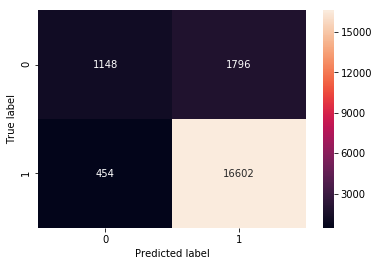

In [145]:
classifier = LogisticRegression(C= 1, penalty='l1')
fit_predict_performance_CM_CV(classifier, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

K-fold cross validation score of model for k = 3 is :
90.24000016882711

Correct Classified Data Point:  17757

Correct % Classified Data Point:  88.785 %

F1-Score on Test set: 93.67010018343446 %

====== Confusion matrix ======= 
[[ 1161  1783]
 [  460 16596]]
Confusion Matrix
      0      1
0  1161   1783
1   460  16596

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      2944
           1       0.90      0.97      0.94     17056

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.81      0.68      0.72     20000
weighted avg       0.88      0.89      0.87     20000



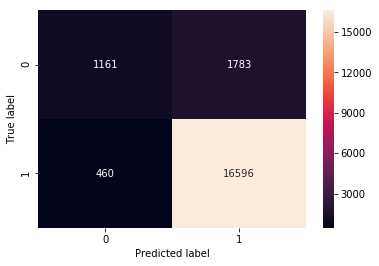

In [161]:
classifier = LogisticRegression(C= 10, penalty='l1')
fit_predict_performance_CM_CV(classifier, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

## Pertubation Test On Tfidf-W2V

In [164]:
pertubation(classifier, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

Accuracy on test set: 88.78%
F1 Score on test set: 93.67%
Non Zero weights: 149

Weights Before Adding Random Noise
[ 0.08382689 -0.09108335  1.31046741 -0.03801764  0.05257637  0.6558632
  0.52426836 -0.8417165   0.59788868  0.60786327  1.33012722  0.8079209
 -0.6658072  -0.7682515   0.09535659  0.65838132  2.48241189  0.12060201
 -0.66391957 -0.03789238 -0.24266338 -0.41055269 -0.21641498  0.44749476
  0.11497129 -1.46059664 -1.81554645 -0.35924677 -0.49605237  0.13955582]

Scoring AFter Adding Random Noise to Train Data

Accuracy on test set: 88.79%
F1 Score on test set: 93.67%
Non Zero weights: 149

Weights After Adding Random Noise
[ 0.08371539 -0.0907644   1.31001408 -0.03747032  0.0526229   0.65509152
  0.52373611 -0.84107027  0.59756007  0.60772133  1.33012705  0.80805818
 -0.66597316 -0.76831741  0.09466712  0.65758736  2.48250793  0.12076544
 -0.66387005 -0.03781436 -0.24218305 -0.41060789 -0.21649406  0.44705772
  0.11452357 -1.46026321 -1.81539318 -0.35965144 -0.49576358  0

### Top Features In Positive and Negative Reviews in Tfidf-W2V

In [165]:
top_features(model, classifier)

	Positive					Negative
_____________________________________________________________________________________
	-4.5793	disappoint     				5.8168	great          
	-2.9177	worst          				4.4599	love           
	-2.7002	bad            				4.3696	best           
	-2.6827	money          				3.3089	delici         
	-2.6395	terribl        				3.0170	good           
	-2.5511	return         				2.8470	excel          
	-2.4631	aw             				2.8120	perfect        
	-2.4475	wast           				2.4949	favorit        
	-2.4435	horribl        				2.3744	find           
	-2.3774	tast           				2.3657	nice           
	-2.2931	stale          				2.2988	wonder         
	-2.1974	thought        				1.9398	easi           
	-2.0879	threw          				1.9235	tasti          
	-2.0732	bland          				1.8016	alway          
	-2.0296	would          				1.8010	keep           
	-2.0076	unfortun       				1.7880	enjoy          
	-1.9815	mayb           				1.7204	thank          
	-1.9345	away           

**==================================================================================================================================**

**Observation on Tfidf-W2V Logestic Regression:**

1] After Implementing different approach to find better Lambda Or C for the Tfidf Model,

    Such as: 
    - Different Lambda|C Model
    - GridSearchCV : C = 10 and Lambda = 0.1
    - RandomSearchCV : C = 1 and Lambda = 1
                       - With L1 Penalty for Both CV
    
        Lambda = 1 i.e C = 1, came out to be Best Lambda|C for the Modeling with GridSearchCV and RandomSearchCV,& by Implementing Train Test Result.
         
### For Lambda = 1 i.e C = 1 : RandomSearchCV | GridSearchCV Result

    - Test Result: 88.75 %
    - CV Result: 90.18 %
    
    - Accuracy:
        - F1 Score: 93 %
        - Recall: 68 %
        - Precision: 81 %
        
    - Correctly Classified Points: 17740/20000
    
### For Lambda = 0.1 i.e C = 10 : RandomSearchCV | GridSearchCV Result

    - Test Result: 88.78 %
    - CV Result: 90.24 %
    
    - Accuracy:
        - F1 Score: 93.67 %
        - Recall: 68 %
        - Precision: 81 %
        
    - Correctly Classified Points: 17757/20000
 
Fpr Lambda = 1 We can observe that even if our Model accuracy is 88.7 % but it is not as good as Bow and Tfidf Model with Best lambda = 1 for Tfidf-W2V.
**==================================================================================================================================**

## Performance Table

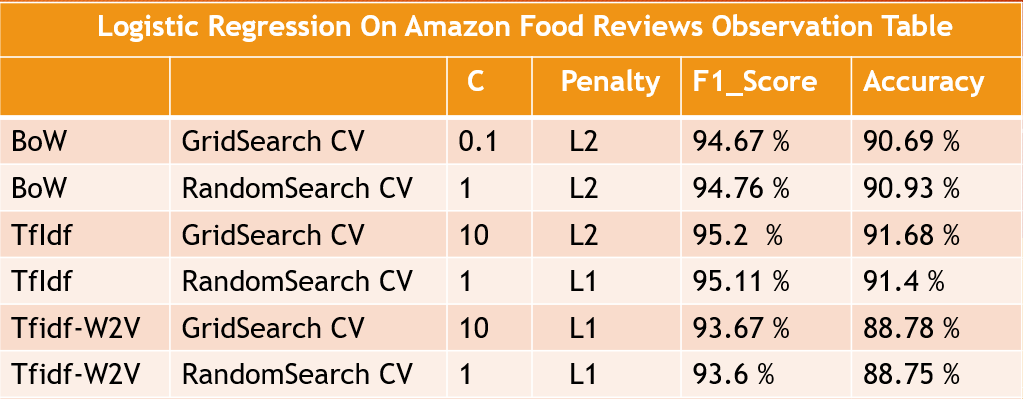

In [167]:
img = 'C:/Users/Ghost/Downloads/AAIC Assignment/Acc.png'
Image(img)

# Conclusion
**1] Features are multi-collinear i.e. they are co-related in Bow and Tfidf Vectorizer whereas TfidfW2v don't have Multi-collinear Features.**

**2] Tfidf Featurization performs best with accuracy of 91.68 and F1-Score of 95.2**

**3] Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used**

**4] Algorithms Logistic Regression is performing better on this data than KNN and Naive Bayes**